In [9]:
%matplotlib notebook
%load_ext autoreload
%pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import skimage
import torch
import nibabel as nib

from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks

import pygalmesh
import meshio

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [24]:
%autoreload
emory4dct = project.imaging.Emory4DCT('/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory')
emory4dct

Emory4DCT('/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory', 10 cases)

In [128]:
def select_regions_by_size(mask, n_regions=1, min_size=0, verbose=True):
    
    # identify connected regions in the mask and measure their size
    regions = skimage.measure.label(mask, background=0)
    region_labels, region_sizes = np.unique(regions, return_counts=True)
    
    # compute the relative sizes of non-backgrond regions
    relative_sizes = region_sizes / region_sizes[1:].sum() * 100
    print(np.round(relative_sizes[1:], 1))

    # sort the regions by size and select the n largest
    regions_by_size = np.argsort(-region_sizes)
    selected_regions = regions_by_size[1:1+n_regions]
    
    # keep only regions that are over the min relative size
    n_ok_size = (relative_sizes[1:] >= min_size).sum()
    selected_regions = selected_regions[:n_ok_size]

    # create new mask with only the selected regions
    new_mask = np.isin(regions, selected_regions).astype(mask.dtype)
    
    # compute how many voxels were affected
    old_count = (mask > 0).sum().astype(int)
    new_count = (new_mask).sum().astype(int)
    n_dropped = old_count - new_count
    pct_dropped = n_dropped / old_count * 100

    print(f'{n_dropped} voxels were dropped, {new_count} are left ({pct_dropped:.1f}% dropped)')
    if pct_dropped > 10:
        print(f'WARNING: {pct_dropped:.0f}% of voxels were dropped!')
        
    return new_mask

mask = np.array([
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
])
select_regions_by_size(mask, n_regions=10, min_size=15, verbose=True)

[40.  40.   6.7 13.3]
3 voxels were dropped, 12 are left (20.0% dropped)


array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [152]:
case = emory4dct[0]
case.load_niftis()
phase = 0

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T00.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T10.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T20.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T30.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T40.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T50.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T60.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T70.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T80.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/NIFTI/case1_T90.nii.gz


In [5]:
total_task_rois = [
    'lung_upper_lobe_right',
    'lung_middle_lobe_right',
    'lung_lower_lobe_right',
    'lung_upper_lobe_left',
    'lung_lower_lobe_left'
]
vessel_task_rois = [
    'lung_trachea_bronchia',
    'lung_vessels'
]
all_task_rois = total_task_rois + vessel_task_rois

In [7]:
%%time

def run_totalsegmentator_tasks(case, phase):
    image_file = case.nifti_file(phase=phase)
    mask_file = case.totalseg_mask_file(phase, roi='lung_regions')
    mask_dir = mask_file.parent
    
    print('Running totalsegmentator task: total')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='total',
        roi_subset=total_task_rois,
    )
    print('Running totalsegmentator task: lung_vessels')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='lung_vessels'
    )
    
run_totalsegmentator_tasks(case, phase)

Running totalsegmentator task: total

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.25s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 11.79s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.09s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


  Predicted in 12.62s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.91s
Running totalsegmentator task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.24s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 9.18s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:01<00:00, 25.68it/s]


  Predicted in 21.12s
Saving segmentations...
Creating lung_vessels.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


Creating lung_trachea_bronchia.nii.gz
  Saved in 0.82s
CPU times: user 11.8 s, sys: 9.03 s, total: 20.8 s
Wall time: 1min 2s


In [40]:
def xview(a, dims=['x', 'y', 'z'], name='regions'):
    return project.visual.XArrayViewer(
        project.utils.as_xarray(a, dims=dims, name=name)
    )

Postprocessing totalseg masks
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_upper_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_middle_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_upper_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_trachea_bronchia.nii.gz
Cleaning /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_vessels.nii.gz
[2.10790561e+01 5.79307149e-03 1.93102383e-03 3.08963813e-02
 3.47584289e-02 1.93102383e-03 3.86204766e-0

Creating /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_regions.nii.gz


<IPython.core.display.Javascript object>


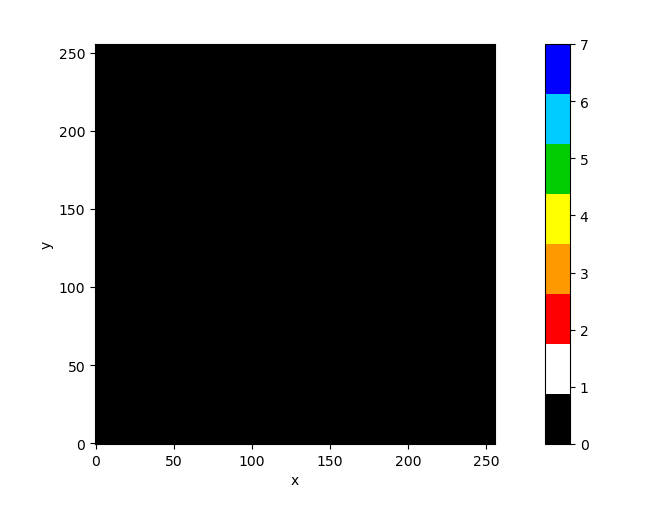

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

CPU times: user 7.86 s, sys: 324 ms, total: 8.18 s
Wall time: 8.55 s


(256, 256, 94)

In [122]:
%%time
def clean_totalseg_masks(case, phase):
    assert all_task_rois[-1] == 'lung_vessels'

    print('Postprocessing totalseg masks')
    regions = []
    for i, roi in enumerate(all_task_rois):
        mask_file = case.totalseg_mask_file(phase=phase, roi=roi)
        
        print(f'Cleaning {mask_file}')
        mask_nifti = nib.load(mask_file)
        mask = mask_nifti.get_fdata()
        
        if roi != 'lung_vessels':
            new_mask = mask #select_regions_by_size(mask, n_regions=2)
    
        else: # lung_vessels           
            new_mask = mask.astype(bool)
            new_mask |= skimage.morphology.skeletonize(mask)
            new_mask &= (np.stack(regions).sum(axis=0) > 0)
            new_mask = select_regions_by_size(new_mask.astype(float), n_regions=2)
        
        regions.append(new_mask * (i + 1))
    
    # combine into single region mask
    regions = np.stack(regions).max(axis=0)

    mask_file = case.totalseg_mask_file(phase, roi='lung_regions')
    print(f'Creating {mask_file}')
    mask_nifti = nib.nifti1.Nifti1Image(regions, mask_nifti.affine)
    nib.save(mask_nifti, mask_file)

    return regions
          
regions = clean_totalseg_masks(case, phase)
xview(regions)
regions.shape

In [172]:
case = emory4dct[7]
case.load_niftis()
phase = 0

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T00.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T10.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T20.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T30.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T40.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T50.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T60.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T70.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T80.nii.gz
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/NIFTI/case8_T90.nii.gz


Creating lung region mask for Case8Deploy phase 0
[100.   0.]
50 voxels were dropped, 924200 are left (0.0% dropped)
[99.3  0.2  0.1  0.   0.2  0.   0.1]
30 voxels were dropped, 4053 are left (0.7% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/TotalSegment/case8_T00/lung_regions2.nii.gz


<IPython.core.display.Javascript object>


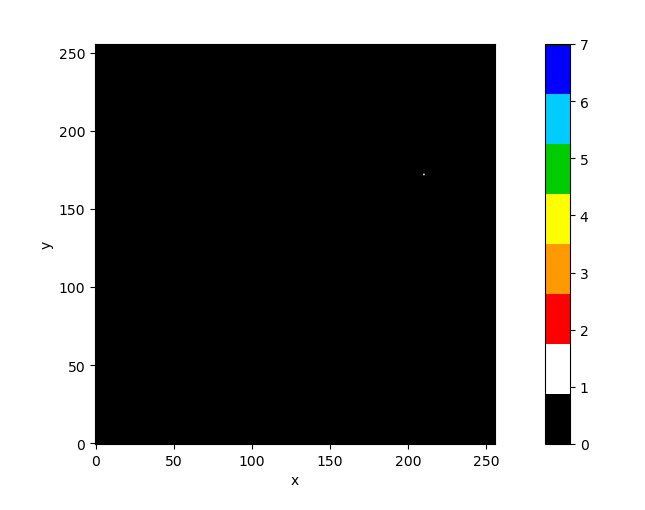

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

CPU times: user 4.72 s, sys: 85.1 ms, total: 4.81 s
Wall time: 5.7 s


In [173]:
%%time

def create_lung_region_mask(case, phase, new_roi):
    print(f'Creating lung region mask for {case.case_name} phase {phase}')
    regions = []
    
    lung_file = case.medpseg_mask_file(phase, roi='lung')
    lung_nifti = nib.load(lung_file)
    lung_mask = lung_nifti.get_fdata().astype(bool)
    lung_mask = select_regions_by_size(lung_mask, n_regions=2, min_size=30)
    regions.append(lung_mask)
    
    #lobes_file = case.medpseg_mask_file(phase, roi='lobes')
    #lobes_mask = nib.load(lobes_file).get_fdata().astype(int)
    #for i in range(5):
    #    lobe_mask = select_regions_by_size(lobes_mask == (i+1), n_regions=1)
    #    regions.append(lobe_mask * (i+1))
    
    airway_file = case.totalseg_mask_file(phase, roi='lung_trachea_bronchia')
    airway_mask = nib.load(airway_file).get_fdata().astype(bool)
    airway_mask = select_regions_by_size(airway_mask, n_regions=1)
    regions.append(airway_mask * 6)
    
    vessel_file = case.totalseg_mask_file(phase, roi='lung_vessels')
    vessel_mask = nib.load(vessel_file).get_fdata().astype(bool)
    vessel_mask |= skimage.morphology.skeletonize(vessel_mask)
    vessel_mask &= (lung_mask | airway_mask)
    regions.append(vessel_mask * 7)
    
    regions_file = case.totalseg_mask_file(phase, roi=new_roi)
    print(f'Saving {regions_file}')
    regions = np.stack(regions).max(axis=0).astype(np.uint16)
    regions_nifti = nib.nifti1.Nifti1Image(regions, lung_nifti.affine)
    nib.save(regions_nifti, regions_file)
    
    return regions

regions = create_lung_region_mask(case, phase, new_roi='lung_regions2')
xview(regions)

In [175]:
def generate_anatomical_mesh(case, phase, mask_roi, mesh_version):
    
    mask_file = case.totalseg_mask_file(phase, mask_roi)
    mask_nifti = nib.load(mask_file)
    mask = mask_nifti.get_fdata()
    resolution = mask_nifti.header.get_zooms()

    print('Generating mesh with pygalmesh')
    mesh = pygalmesh.generate_from_array(
        mask.astype(np.uint16),
        voxel_size=resolution,
        max_cell_circumradius={
            'default': 10.0,
            6: 5.0, # airways
            7: 2.0, # vessels
        },
        max_facet_distance=1.5,
        lloyd=True,
        odt=True
    )
    print('Postprocessing mesh')
    mesh = project.meshing.remove_unused_points(mesh)

    tetra_cells = mesh.get_cells_type('tetra')
    mesh.cells = [meshio.CellBlock('tetra', tetra_cells)]
    
    case.mesh_dir.mkdir(exist_ok=True)
    mesh_file = case.mesh_file(phase, mask_roi, mesh_version)
    print(f'Saving {mesh_file}')
    meshio.xdmf.write(mesh_file, mesh)

    mesh, cell_labels = project.meshing.load_mesh_fenics(mesh_file)  
    return mesh

generate_anatomical_mesh(case, phase, mask_roi='lung_regions2', mesh_version=11)

Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/pygalmesh/case8_T00_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case8Deploy/pygalmesh/case8_T00_lung_regions2_11.xdmf... 20049


```






```

In [176]:
%%time
for case in emory4dct.cases:
    for phase in emory4dct.phases:
        regions = create_lung_region_mask(case, phase, new_roi='lung_regions2')
        mesh = generate_anatomical_mesh(case, phase, mask_roi='lung_regions2', mesh_version=11)

Creating lung region mask for Case1Pack phase 0
[56.8 43.2]
0 voxels were dropped, 983291 are left (0.0% dropped)
[99.5  0.   0.1  0.1  0.   0.1  0.1  0.1  0.   0. ]
38 voxels were dropped, 7031 are left (0.5% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T00/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/pygalmesh/case1_T00_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/pygalmesh/case1_T00_lung_regions2_11.xdmf... 7770
Creating lung region mask for Case1Pack phase 10
[56.7 43.3]
0 voxels were dropped, 977565 are left (0.0% dropped)
[99.2  0.   0.   0.1  0.1  0.   0.   0.1  0.1  0.   0.2  0.   0.   0.
  0.   0.   0. ]
57 voxels were dropped, 6767 are left (0.8% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case1Pack/TotalSegment/case1_T10/lung_regions2.nii.gz
Generating

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case2Pack/pygalmesh/case2_T20_lung_regions2_11.xdmf... 20193
Creating lung region mask for Case2Pack phase 30
[100.]
0 voxels were dropped, 1217513 are left (0.0% dropped)
[99.5  0.2  0.2  0.   0.   0.   0.1]
31 voxels were dropped, 6374 are left (0.5% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case2Pack/TotalSegment/case2_T30/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case2Pack/pygalmesh/case2_T30_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case2Pack/pygalmesh/case2_T30_lung_regions2_11.xdmf... 18174
Creating lung region mask for Case2Pack phase 40
[100.   0.]
1 voxels were dropped, 1202686 are left (0.0% dropped)
[ 0.  99.6  0.1  0.1  0.   0.1  0. ]
22 voxels were dropped, 6242 are left (0.4% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case2Pa

Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case3Pack/pygalmesh/case3_T60_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case3Pack/pygalmesh/case3_T60_lung_regions2_11.xdmf... 22910
Creating lung region mask for Case3Pack phase 70
[53.7 46.3]
0 voxels were dropped, 1167658 are left (0.0% dropped)
[99.3  0.   0.3  0.4  0. ]
58 voxels were dropped, 7874 are left (0.7% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case3Pack/TotalSegment/case3_T70/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case3Pack/pygalmesh/case3_T70_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case3Pack/pygalmesh/case3_T70_lung_regions2_11.xdmf... 22421
Creating lung region mask for Case3Pack phase 80
[53.9 46.1]
0 voxels were dropped, 1207078 are left (0.0% dropped)

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case4Pack/pygalmesh/case4_T90_lung_regions2_11.xdmf... 24599
Creating lung region mask for Case5Pack phase 0
[55.8 44.2]
0 voxels were dropped, 976959 are left (0.0% dropped)
[99.9  0.   0.   0.   0. ]
5 voxels were dropped, 5727 are left (0.1% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case5Pack/TotalSegment/case5_T00/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case5Pack/pygalmesh/case5_T00_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case5Pack/pygalmesh/case5_T00_lung_regions2_11.xdmf... 11800
Creating lung region mask for Case5Pack phase 10
[55.6 44.4]
0 voxels were dropped, 962149 are left (0.0% dropped)
[99.8  0.1  0.1]
9 voxels were dropped, 4769 are left (0.2% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case5Pack/TotalSegment/case5_T10/lung

Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case6Pack/pygalmesh/case6_T30_lung_regions2_11.xdmf... 26769
Creating lung region mask for Case6Pack phase 40
[55.2 44.8]
0 voxels were dropped, 407626 are left (0.0% dropped)
[ 0.1 99.5  0.   0.3  0.1]
14 voxels were dropped, 2829 are left (0.5% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case6Pack/TotalSegment/case6_T40/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case6Pack/pygalmesh/case6_T40_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case6Pack/pygalmesh/case6_T40_lung_regions2_11.xdmf... 27746
Creating lung region mask for Case6Pack phase 50
[55.5 44.5]
0 voxels were dropped, 395430 are left (0.0% dropped)
[100.]
0 voxels were dropped, 2649 are left (0.0% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case6Pack/TotalSegment/case6_T50/lung_regions

Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T70_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T70_lung_regions2_11.xdmf... 20553
Creating lung region mask for Case7Pack phase 80
[54.6 45.4]
0 voxels were dropped, 471792 are left (0.0% dropped)
[98.   0.   0.   0.   1.4  0.   0.5  0.   0. ]
91 voxels were dropped, 4352 are left (2.0% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/TotalSegment/case7_T80/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T80_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case7Pack/pygalmesh/case7_T80_lung_regions2_11.xdmf... 20896
Creating lung region mask for Case7Pack phase 90
[54.6 45.4]
0 voxels were dropped, 490720 are l

[96.8  3.2]
72 voxels were dropped, 2192 are left (3.2% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/TotalSegment/case9_T10/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T10_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T10_lung_regions2_11.xdmf... 14126
Creating lung region mask for Case9Pack phase 20
[54.8 45.2]
0 voxels were dropped, 299292 are left (0.0% dropped)
[ 0.1 98.4  1.3  0.   0.1]
32 voxels were dropped, 1981 are left (1.6% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/TotalSegment/case9_T20/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case9Pack/pygalmesh/case9_T20_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emo

[100.   0.]
1 voxels were dropped, 4438 are left (0.0% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/TotalSegment/case10_T50/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T50_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T50_lung_regions2_11.xdmf... 16383
Creating lung region mask for Case10Pack phase 60
[60.6 39.4]
0 voxels were dropped, 558755 are left (0.0% dropped)
[ 0.  99.8  0.   0.1]
9 voxels were dropped, 4701 are left (0.2% dropped)
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/TotalSegment/case10_T60/lung_regions2.nii.gz
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/Case10Pack/pygalmesh/case10_T60_lung_regions2_11.xdmf
Loading /ocean/projects/asc170022p/shared/Data/4DLungCT